In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

In [2]:
# rho_hat = df["Density"]
# q_hat = df["Flow"]
# print(max(q_hat))
# C_i = np.mean(sorted(q_hat)[-5:])
# print("C_i", C_i)
# K = len(rho_hat)


q_hat = (np.load("flow_20sec_400m_1hr.npy"))
print(np.max(q_hat))
rho_hat = (np.load("density_20sec_400m_1hr.npy"))
v_hat = q_hat/rho_hat
print(rho_hat.shape)
flattened_q_hat = q_hat.flatten()
print(max(flattened_q_hat))
flattened_rho_hat = rho_hat.flatten()
C_i = np.mean(np.sort(flattened_q_hat)[-5:])
print("C_i", C_i)
K = len(flattened_rho_hat)
print("K", K)

6570.120599999998
(180, 16)
6570.120599999998
C_i 6456.700259999984
K 2880


In [3]:
model = ConcreteModel()
model.k = RangeSet(0, K - 1)

# Data parameters
model.rho_hat = Param(model.k, initialize={k: flattened_rho_hat[k] for k in range(K)})
model.q_hat = Param(model.k, initialize={k: flattened_q_hat[k] for k in range(K)})
model.C = Param(initialize=C_i)  # FIXED

# Variables to optimize
model.rho_crit = Var(bounds=(1e-2, max(flattened_rho_hat)), initialize=np.median(flattened_rho_hat))
model.V_free = Var(bounds=(10, 150), initialize=60)
model.a = Var(bounds=(0.01, 10), initialize=1.0)

# Smoothed piecewise flow function
def q_pred_expr(model, k):
    rho = model.rho_hat[k]
    rho_crit = model.rho_crit
    V_free = model.V_free
    a = model.a
    Q = rho * V_free * exp(-1/a * (rho/rho_crit)**a)
    return Q

model.q_pred = Expression(model.k, rule=q_pred_expr)

# Objective function
def obj_rule(model):
    return sum((model.q_pred[k] - model.q_hat[k])**2 for k in model.k)

model.obj = Objective(rule=obj_rule, sense=minimize)
print("Initial guess:")
print(f"rho_crit = {value(model.rho_crit)}")
print(f"V_free = {value(model.V_free)}")
print(f"a = {value(model.a)}")

# Solve
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)

# Output
print("Optimized Parameters:")
print(f"rho_crit = {value(model.rho_crit):.3f}")
print(f"V_free = {value(model.V_free):.3f}")
print(f"a = {value(model.a):.3f}")

Initial guess:
rho_crit = 93.22999675
V_free = 60
a = 1.0
Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of eq

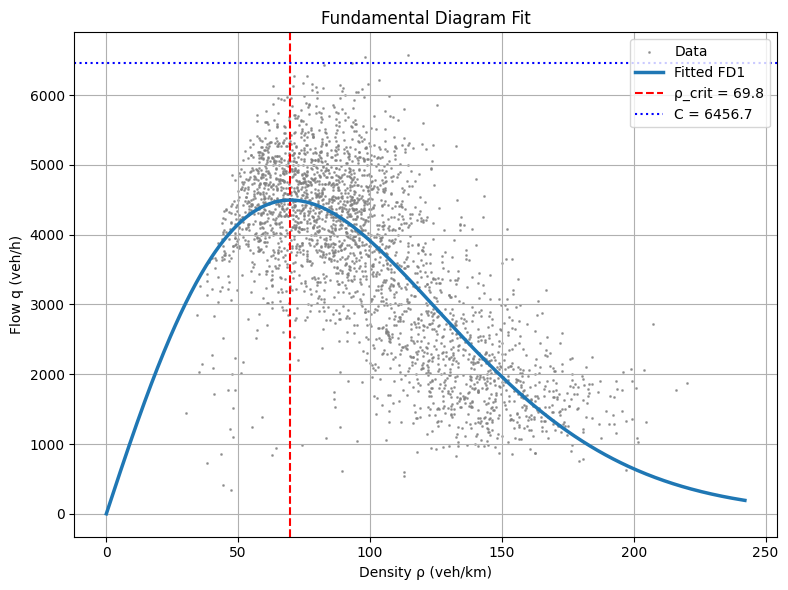

In [4]:
rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)
C = np.mean(sorted(flattened_q_hat)[-5:])  # same C you used in Pyomo

# Define Q(rho) using the original piecewise FD1
def Q_fd1(rho):
    rho = np.array(rho)
    Q_free = V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
    # Q = np.where(rho <= rho_crit, Q_free, C)
    Q = Q_free
    return Q

# Generate smooth rho values for curve
rho_range = np.linspace(0, max(flattened_rho_hat)*1.1, 500)
q_fit = Q_fd1(rho_range)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, label='Data', s = 1)
plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.axvline(rho_crit, color='red', linestyle='--', label=f'ρ_crit = {rho_crit:.1f}')
plt.axhline(C, color='blue', linestyle=':', label=f'C = {C:.1f}')
plt.xlabel("Density ρ (veh/km)")
plt.ylabel("Flow q (veh/h)")
plt.title("Fundamental Diagram Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
def metanet_param_fit(v_hat, rho_hat, q_hat, T, l, initial_traffic_state, downstream_density, num_calibrated_segments):
    initial_flow_or = initial_traffic_state
    
    num_timesteps, num_segments = v_hat.shape
    
    model = ConcreteModel()
    model.t = RangeSet(0, num_timesteps-1)
    model.i = RangeSet(0, num_segments-1)
    model.segment_ix = RangeSet(0, num_calibrated_segments-1)
    model.num_segments = num_segments
    model.num_calibrated_segments = num_calibrated_segments

    # Fixed params
    model.T = Param(initialize=T)
    model.l = Param(initialize=l)

    # Number of lanes (per calibrated segment)
    model.n_lanes = Var(model.segment_ix, bounds=(3, 5), initialize=3)

    # Parameters to estimate
    model.eta_high = Var(model.segment_ix, bounds=(10.0,200.0), initialize=30.0)
    model.tau = Var(model.segment_ix, bounds=(0, 80.0), initialize=18/3600)
    model.K = Var(model.segment_ix, bounds=(0, 50.0), initialize=40.0)
    model.rho_crit = Var(model.segment_ix, bounds=(1e-2, np.max(rho_hat)), initialize=20.0)
    model.v_free = Var(model.segment_ix, bounds=(10, 150), initialize=120.0)
    model.a = Var(model.segment_ix, bounds=(0.01, 10), initialize=1.0)

    # beta is for s(i) = beta/(1-beta)*q(i) 
    model.beta = Var(model.segment_ix, bounds=(0, 1), initialize=0.5)
    # gamma is for r(i) = gamma/(1-gamma) * q(i)
    model.gamma = Var(model.segment_ix, bounds=(0, 1), initialize=0.5)

    # Variables to predict (per-lane values)
    model.v_pred = Var(model.t, model.i, bounds=(0, 150), 
                       initialize={(t,i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_pred = Var(model.t, model.i, bounds=(1e-3, 300), 
                         initialize={(t,i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    model.q_pred = Var(model.t, model.i, bounds=(1e-3, 10000), 
                       initialize={(t,i): float(q_hat[t, i]) for t in model.t for i in model.i})
    
    # Initial conditions
    model.constraints = ConstraintList()
    for i in range(num_segments):
        model.constraints.add(model.v_pred[0,i] == v_hat[0, i].item())
        model.constraints.add(model.rho_pred[0,i] == rho_hat[0, i].item())

    # Observed data
    model.v_hat = Param(model.t, model.i, initialize={(t, i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_hat = Param(model.t, model.i, initialize={(t, i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    model.q_hat = Param(model.t, model.i, initialize={(t, i): float(q_hat[t, i]) for t in model.t for i in model.i})

    # Dynamics functions
    def density_dynamics(current, inflow, outflow, T, l, lanes):
        # s_i = beta/(1-beta)* inflow
        # r_i = gamma/(1-gamma) * outflow
        
        return current + T/(l) * (inflow - outflow) # add r(t)- s(t) 
    
    def calculate_V(m, rho, VSL, seg):
        return m.v_free[seg] * exp(-1 / m.a[seg] * (rho / m.rho_crit[seg])**m.a[seg])
    
    def velocity_dynamics(m, current, prev_state, density, next_density, VSL, T, l, seg):
        tau = m.tau[seg]
        eta = m.eta_high[seg]
        K = m.K[seg]
        v_eq = calculate_V(m, density, VSL, seg)
        term1 = T / tau * (v_eq - current)
        term2 = T / l * current * (prev_state - current)
        term3 = (eta * T) / (tau * l) * (next_density - density) / (density + K)
        return current + term1 + term2 - term3

    # Density dynamics
    def rho_update(m, t, i):
        if t == 0:
            return Constraint.Skip
        seg = i // (m.num_segments // m.num_calibrated_segments)
        if i == 0:
            current = m.rho_pred[t-1,0]
            inflow = initial_flow_or[t-1, 0]
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
        else:
            current = m.rho_pred[t-1,i]
            inflow = m.rho_pred[t-1, i-1] * m.v_pred[t-1, i-1] 
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
        return m.rho_pred[t,i] == density_dynamics(current, inflow, outflow, model.T, model.l, model.n_lanes[i])
    model.rho_dyn = Constraint(model.t, model.i, rule=rho_update)

    # Velocity dynamics
    VSL = 150
    def v_update(m, t, i):
        seg = i // (m.num_segments // m.num_calibrated_segments)
        if t == 0:
            return Constraint.Skip
        if i == 0:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i]
            density = m.rho_pred[t-1, i] / m.n_lanes[seg]
            next_density = m.rho_pred[t-1, i+1] / m.n_lanes[seg+1]
        elif i == num_segments-1:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i-1]
            density = m.rho_pred[t-1, i] / m.n_lanes[seg]
            next_density = downstream_density[t-1] / m.n_lanes[seg]
        else:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i-1]
            density = m.rho_pred[t-1, i] / m.n_lanes[seg]
            next_density = m.rho_pred[t-1, i+1] / m.n_lanes[seg+1]
        return m.v_pred[t,i] == velocity_dynamics(m, current, prev_state, density, next_density, VSL, model.T, model.l, seg)
    model.v_dyn = Constraint(model.t, model.i, rule=v_update)

    # Objective: per-lane error
    def loss_fn(m):
        return sum(
            (m.v_pred[t, i] - m.v_hat[t, i])**2
             # (m.rho_pred[t, i] - m.rho_hat[t, i] / m.n_lanes[i // (m.num_segments // m.num_calibrated_segments)])**2 +
             # (m.v_pred[t,i] * m.rho_pred[t,i] - m.q_hat[t, i] / m.n_lanes[i // (m.num_segments // m.num_calibrated_segments)])**2
            for t in m.t for i in m.i
        )
    model.loss = Objective(rule=loss_fn, sense=minimize)

    # Solve
    solver = SolverFactory("ipopt")
    solver.options['max_iter'] = 20000 
    solver.solve(model, tee=False)
    return model


In [ ]:
def smooth_inflow(inflow, window_size=2):
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=inflow)
    return smoothed

T = 20/3600
l = 0.4
time_segments = np.arange(0,3600, T * 3600)
num_timesteps, num_segments = np.shape(rho_hat)

SPEED_LIMIT = 150 # KM/H
for t in range(num_timesteps):
    for i in range(num_segments):
        if rho_hat[t,i] == 0.0:
            rho_hat[t,i] = 1e-3
print(np.min(rho_hat))

v_hat = q_hat/rho_hat

num_calibrated_segments = num_segments - 2
print("q_hat shape", q_hat.shape)

initial_flow = q_hat[:, 0:1]

initial_flow = smooth_inflow(initial_flow)
initial_traffic_state = initial_flow
segment_rho_hat = rho_hat[:, 1:num_calibrated_segments+1]       # shape (time, segment)
segment_v_hat = v_hat[:, 1:num_calibrated_segments+1]
segment_q_hat = q_hat[:, 1:num_calibrated_segments+1]
downstream_density = rho_hat[:, -1:]
downstream_density = smooth_inflow(downstream_density)
np.save('initial_flow.npy', initial_flow)
np.save('downstream_density.npy', downstream_density)

# Transpose before passing
res_model = metanet_param_fit(
    segment_v_hat,
    segment_rho_hat,
    segment_q_hat, T, l,
    initial_traffic_state, downstream_density,
    num_calibrated_segments
)
num_timesteps, num_segments = segment_v_hat.shape

v_pred_array = np.zeros((num_timesteps, num_segments))
rho_pred_array = np.zeros((num_timesteps, num_segments))

# Fill arrays with values from the Pyomo model
for t in range(num_timesteps):  # Pyomo index starts at 1
    for i in range(num_segments):
        v_pred_array[t, i] = value(res_model.v_pred[t, i])
        rho_pred_array[t, i] = value(res_model.rho_pred[t, i])

# Parameter arrays
tau_array = np.zeros(num_calibrated_segments)
K_array = np.zeros(num_calibrated_segments)
eta_high_array = np.zeros(num_calibrated_segments)
rho_crit_array = np.zeros(num_calibrated_segments)
v_free_array = np.zeros(num_calibrated_segments)
a_array = np.zeros(num_calibrated_segments)
num_lanes_array = np.zeros(num_calibrated_segments)





30.229998374999997
q_hat shape (180, 16)


In [ ]:
for seg in range(num_calibrated_segments):
    tau_array[seg] = value(res_model.tau[seg])
    K_array[seg] = value(res_model.K[seg])
    eta_high_array[seg] = value(res_model.eta_high[seg])
    rho_crit_array[seg] = value(res_model.rho_crit[seg])
    v_free_array[seg] = value(res_model.v_free[seg])
    a_array[seg] = value(res_model.a[seg])
    num_lanes_array[seg] = value(res_model.n_lanes[seg])

    print("Segment", seg)
    print("tau:", tau_array[seg])
    print("K:", K_array[seg])
    print("eta high:", eta_high_array[seg])
    print("rho_crit:", rho_crit_array[seg])
    print("v_free:", v_free_array[seg])
    print("a:", a_array[seg])
    print("num_lanes:", num_lanes_array[seg])
    print("------------")

# Save everything
q_array = v_pred_array*rho_pred_array
np.save("tau.npy", tau_array)
np.save("K.npy", K_array)
np.save("eta_high.npy", eta_high_array)
np.save("rho_crit.npy", rho_crit_array)
np.save("v_free.npy", v_free_array)
np.save("a.npy", a_array)
np.save("num_lanes.npy", num_lanes_array)
np.save("q_pred.npy", q_array)
np.save("v_pred.npy", v_pred_array)
np.save("rho_pred.npy", rho_pred_array)

In [ ]:
import matplotlib.pyplot as plt

# # Collect scaled predictions across all segments
all_rho_pred = rho_pred_array

print(all_rho_pred.shape)
all_v_pred = v_pred_array
all_q_pred = all_rho_pred*all_v_pred
# for seg in range(num_segments-2):
#     lane_num = best_results["lane_num"][seg]  # optimal lane count
#     rho_pred_seg = best_results["rho_pred"][seg] * lane_num
#     v_pred_seg = best_results["v_pred"][seg]
#     q_pred_seg = rho_pred_seg * v_pred_seg

#     all_rho_pred.append(rho_pred_seg)
#     all_q_pred.append(q_pred_seg)
#     all_v_pred.append(v_pred_seg)

# Stack predictions
all_rho_pred = np.hstack(all_rho_pred)
all_q_pred = np.hstack(all_q_pred)
all_v_pred = np.hstack(all_v_pred)
# Plot
plt.figure(figsize=(6, 4))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, s=1, label='Data (measured)')
plt.scatter(all_rho_pred, all_q_pred, alpha=0.6, s=1, label='Predicted')
plt.xlabel("Density (veh/km)")
plt.ylabel("Flow (veh/hr)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted, scaled by lanes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(num_lanes_array)), num_lanes_array, color="skyblue", edgecolor="black")

plt.xlabel("Segment Index")
plt.ylabel("Number of Lanes")
plt.title("Number of Lanes per Segment")
plt.xticks(np.arange(len(num_lanes_array)))  # show all indices
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

In [ ]:
import numpy as np

def mape(flow_hat, flow_pred):
    """
    Compute the Mean Absolute Percentage Error (MAPE) between ground truth and prediction.

    Parameters:
        flow_hat (np.ndarray): Ground truth array of shape [t, i]
        flow_pred (np.ndarray): Predicted array of shape [t, i]

    Returns:
        float: The mean absolute percentage error (in percent)
    """
    # Avoid division by zero by masking out zero ground truth values
    mask = flow_hat != 0
    # print(flow_hat.shape)
    # print(flow_pred.shape)
    error = np.abs((flow_pred[mask] - flow_hat[mask]) / flow_hat[mask])
    return np.mean(error) * 100
def rmse(flow_hat, flow_pred):
    """
    Compute the Root Mean Squared Error (RMSE) between ground truth and prediction.

    Parameters:
        flow_hat (np.ndarray): Ground truth array of shape [t, i]
        flow_pred (np.ndarray): Predicted array of shape [t, i]

    Returns:
        float: The root mean squared error
    """
    error = flow_pred - flow_hat
    mse = np.mean(np.square(error))
    return np.sqrt(mse)


In [ ]:
print(all_v_pred.shape)
q_array = rho_pred_array*v_pred_array
print("rho mape", mape(rho_hat[:,1:-1], rho_pred_array))
print("q mape", mape(q_hat[:, 1:-1], q_array))
print("v mape", mape(v_hat[:, 1:-1], v_pred_array))
print("----------------")
print("rho rmse", rmse(rho_hat[:,1:-1], rho_pred_array))
print("q rmse", rmse(q_hat[:, 1:-1], q_array))
print("v rmse", rmse(v_hat[:, 1:-1], v_pred_array))

In [ ]:
rho_plot_pred = rho_pred_array
rho_plot_true = rho_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(rho_plot_pred.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Segment Index')
axes[0].set_title('Predicted Density ($\\rho$)')
fig.colorbar(im0, ax=axes[0], label='Density')

# --- Ground Truth ---
im1 = axes[1].imshow(rho_plot_true.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[1].set_xlabel('Time Step')
axes[1].set_title('Ground Truth Density ($\\rho$)')
fig.colorbar(im1, ax=axes[1], label='Density')

plt.tight_layout()
plt.show()


In [ ]:
rho_plot_pred = v_pred_array
rho_plot_true = v_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(rho_plot_pred.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Segment Index')
axes[0].set_title('Predicted Velocity ($\\rho$)')
fig.colorbar(im0, ax=axes[0], label='Density')

# --- Ground Truth ---
im1 = axes[1].imshow(rho_plot_true.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[1].set_xlabel('Time Step')
axes[1].set_title('Ground Truth Velocity ($\\rho$)')
fig.colorbar(im1, ax=axes[1], label='Velocity')

plt.tight_layout()
plt.show()


In [ ]:
rho_plot_pred = rho_pred_array*v_pred_array
rho_plot_true = q_hat[:, 1:-1]

print("Pred shape:", rho_plot_pred.shape)
print("True shape:", rho_plot_true.shape)
print("Max true density:", np.max(rho_plot_true))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- Prediction ---
im0 = axes[0].imshow(rho_plot_pred.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Segment Index')
axes[0].set_title('Predicted Flow ($\\rho$)')
fig.colorbar(im0, ax=axes[0], label='Flow')

# --- Ground Truth ---
im1 = axes[1].imshow(rho_plot_true.T, aspect='auto', origin='lower',
                     cmap='RdYlGn', interpolation="none")
axes[1].set_xlabel('Time Step')
axes[1].set_title('Ground Truth Flow ($\\rho$)')
fig.colorbar(im1, ax=axes[1], label='Flow')

plt.tight_layout()
plt.show()
